In [1]:
%load_ext autoreload
%autoreload 2

# test mini world

In [2]:
import gym_miniworld

In [3]:
# env = gym_miniworld.miniworld.MiniWorldEnv()
# env = gym_miniworld.envs.MiniWorldEnv()

In [4]:
env_maze = gym_miniworld.envs.Maze()

In [5]:
obs = env_maze.reset()

In [6]:
obs.shape

(60, 80, 3)

# plot

In [7]:
import matplotlib.pyplot as plt

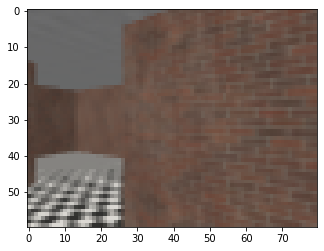

In [8]:
plt.imshow(obs)

In [ ]:
render1 = env_maze.render(view='top', mode='rgb_array')

In [ ]:
plt.imshow(render1)

# test GPPN maze functions

In [ ]:
%pwd

In [ ]:
%cd '/mnt/Z-LabData-6T/zlf-nfs-hdd/projects/2021-IEP/SymPlan'

In [ ]:
from envs.maze_env import generate_maze, RandomMaze

In [ ]:
maze1 = generate_maze(maze_size=5, decimation=0.2)

In [ ]:
maze1

In [ ]:
plt.imshow(maze1)

# find valid locations

In [ ]:
import numpy as np

In [ ]:
def get_valid_pos(map_np, valid_sym=0, return_np=False):
    """return valid (0, empty) grid cells for goal/start position"""
    res = np.argwhere(map_np == valid_sym)
    return res if return_np else list(map(tuple, res.tolist()))

In [ ]:
get_valid_pos(maze1, valid_sym=1)

# inherent class & add loading map from GPPN maze class

In [ ]:
from gym_miniworld.miniworld import MiniWorldEnv
from gym_miniworld.envs import Maze

In [ ]:
class MazeVisNav(MiniWorldEnv):
    def __init__(
            self,
            maze_map,
            obs_width=80,
            obs_height=60,
    ):
        self.maze_map = maze_map
        self.num_rows, self.num_cols = maze_map.shape[0], maze_map.shape[1]  # maze_map.shape[0] - 2, maze_map.shape[1] - 2

        self.valid_pos = self.get_valid_pos(self.maze_map, valid_sym=1, return_np=False)

        self.room_size = 1
        self.gap_size = 0.01  # room gap size / wall thickness

        self.num_views = 4
        self.num_rgb = 3
        self.obs_dim = (obs_height, obs_width, self.num_rgb)

        self.obs_width = obs_width
        self.obs_height = obs_height

        super().__init__(obs_width=obs_width, obs_height=obs_height)

    def _gen_world(self):
        # _rooms = np.empty(shape=(self.num_rows, self.num_cols))
        _rooms = {}

        # initialize all rooms
        # For each row
        for _row in range(self.num_rows):
            # For each column
            for _col in range(self.num_cols):
                # check if the current cell is a corridor cell
                # if (_col, _row) not in self.valid_pos:  # TODO this is added
                if (_row, _col) not in self.valid_pos:  # TODO this is added
                    # _rooms[_i][_j] = None
                    continue

                # compute the boundary
                # min_x = _j * (self.room_size + self.gap_size)
                min_x = _col * (self.room_size + self.gap_size)
                max_x = min_x + self.room_size

                # min_z = _i * (self.room_size + self.gap_size)
                min_z = _row * (self.room_size + self.gap_size)
                max_z = min_z + self.room_size

                # add the room
                room = self.add_rect_room(
                    min_x=min_x,
                    max_x=max_x,
                    min_z=min_z,
                    max_z=max_z,
                    wall_tex='brick_wall'
                )

                # _rooms[_i][_j] = room
                _rooms[_row, _col] = room
                # _rooms[_col, _row] = room

        # record visited room
        visited = set()

        # connect the neighbors based on the map info
        for room_loc in self.valid_pos:
            # locate the current room
            # room = _rooms[room_loc[0]][room_loc[1]]
            room = _rooms[room_loc]

            # add the room
            visited.add(room)

            # compute the neighbors
            neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # up, down, left, right

            # loop valid neighbors
            for d_col, d_row in neighbors:
                # _nj = room_loc[1] + di
                # _ni = room_loc[0] + dj
                n_col = room_loc[1] + d_col
                n_row = room_loc[0] + d_row

                # check validation
                if n_row < 0 or n_row >= self.num_rows:
                    continue
                if n_col < 0 or n_col >= self.num_cols:
                    continue

                # TODO valid pos
                # if (n_col, n_row) not in self.valid_pos:
                if (n_row, n_col) not in self.valid_pos:
                    continue

                # neighbor = _rooms[_ni][_nj]
                # neighbor = _rooms[n_col, n_row]
                neighbor = _rooms[n_row, n_col]

                if neighbor in visited:
                    continue

                if d_col == 0:
                    self.connect_rooms(room, neighbor, min_x=room.min_x, max_x=room.max_x)
                elif d_row == 0:
                    self.connect_rooms(room, neighbor, min_z=room.min_z, max_z=room.max_z)

        # > no need to place goal
        # self.box = self.place_entity(Box(color='red'))

        self.place_agent()

    def render_pano(self, pos, with_top=False):
        """
        Helper for rendering egocentric panoramic images
        """

        pano_obs = np.empty(
            shape=(self.num_views, self.obs_height, self.obs_width, self.num_rgb),
            dtype=np.uint8
        )

        # > set position; note: swap col and row!
        self.agent.pos = np.array([pos[1] + 0.5, 0., pos[0] + 0.5])

        for _i, _dir in enumerate(np.arange(0, 2 * np.pi, np.pi / 2)):
            # > set direction/orientation
            self.agent.dir = _dir
            print(f'(Debug) position = {self.agent.pos}, orientation = {self.agent.dir}')

            # > retrieve observation
            pano_obs[_i] = self.render_obs()

        # > retrieve top-down observation for visualization
        if with_top:
            top_obs = self.render_top_view()
            return pano_obs, top_obs
        else:
            return pano_obs

    def get_all_pano(self, debug_top=False):
        # > panoramic (4-direction) RGB images (e.g., 32 x 32 x 3) for every location (e.g., 5 x 5)
        pos2images = np.zeros((self.num_rows, self.num_cols, self.num_views) + self.obs_dim,
                              dtype=np.uint8)
        # e.g. 5 x 5 x (4 x 32 x 32 x 3)

        # > fill actual images
        for pos in self.valid_pos:
            if debug_top:
                pano_obs, top_obs = self.render_pano(pos=pos, with_top=True)
                plot_pano(pano_obs, top_obs)
            else:
                pano_obs = self.render_pano(pos=pos, with_top=False)

            pos2images[pos[0]][pos[1]] = pano_obs

        return pos2images

    @staticmethod
    def get_valid_pos(maze_map, valid_sym=0, return_np=False):
        """return valid (0, empty) grid cells for goal/start position"""
        res = np.argwhere(maze_map == valid_sym)
        return res if return_np else list(map(tuple, res.tolist()))

In [ ]:
vis_maze = MazeVisNav(maze_map=maze1, obs_width=64, obs_height=64)

In [ ]:
render1 = vis_maze.render(view='top', mode='rgb_array')
plt.imshow(render1)

In [ ]:
plt.imshow(maze1)

# test rendering egocentric panoramic images

In [ ]:
obs = vis_maze.reset()

In [ ]:
# pano_obs = vis_maze.render_pano(vis_maze.valid_pos[10])
# pano_obs = vis_maze.render_pano([2, 4])
# pano_obs = vis_maze.render_pano([1.5, 1.5])
# pano_obs = vis_maze.render_pano([0.5, 0.5])
pano_obs, top_obs = vis_maze.render_pano([1, 1], with_top=True)

In [ ]:
from utils.vis_visual_nav import plot_pano

In [ ]:
fig = plot_pano(pano_obs, top_obs=top_obs)

### plot full obs

In [ ]:
pos2images = vis_maze.get_all_pano(debug_top=True)

# test aggregated func

In [ ]:
from nav_wrapper import MazeVisNav

In [ ]:
maze2 = generate_maze(maze_size=7, decimation=0.2)

In [ ]:
env = MazeVisNav(maze_map=maze2, obs_width=64, obs_height=64)

In [ ]:
obs = env.reset()

In [ ]:
pano_obs = env.get_all_pano(debug_top=True)

In [20]:
from gym_miniworld.miniworld import MiniWorldEnv
from gym_miniworld.envs import Maze

In [21]:
class MazeVisNav(MiniWorldEnv):
    def __init__(
            self,
            maze_map,
            obs_width=80,
            obs_height=60,
    ):
        self.maze_map = maze_map
        self.num_rows, self.num_cols = maze_map.shape[0], maze_map.shape[1]  # maze_map.shape[0] - 2, maze_map.shape[1] - 2

        self.valid_pos = self.get_valid_pos(self.maze_map, valid_sym=1, return_np=False)

        self.room_size = 1
        self.gap_size = 0.01  # room gap size / wall thickness

        self.num_views = 4
        self.num_rgb = 3
        self.obs_dim = (obs_height, obs_width, self.num_rgb)

        self.obs_width = obs_width
        self.obs_height = obs_height

        super().__init__(obs_width=obs_width, obs_height=obs_height)

    def _gen_world(self):
        # _rooms = np.empty(shape=(self.num_rows, self.num_cols))
        _rooms = {}

        # initialize all rooms
        # For each row
        for _row in range(self.num_rows):
            # For each column
            for _col in range(self.num_cols):
                # check if the current cell is a corridor cell
                # if (_col, _row) not in self.valid_pos:  # TODO this is added
                if (_row, _col) not in self.valid_pos:  # TODO this is added
                    # _rooms[_i][_j] = None
                    continue

                # compute the boundary
                # min_x = _j * (self.room_size + self.gap_size)
                min_x = _col * (self.room_size + self.gap_size)
                max_x = min_x + self.room_size

                # min_z = _i * (self.room_size + self.gap_size)
                min_z = _row * (self.room_size + self.gap_size)
                max_z = min_z + self.room_size

                # add the room
                room = self.add_rect_room(
                    min_x=min_x,
                    max_x=max_x,
                    min_z=min_z,
                    max_z=max_z,
                    wall_tex='brick_wall'
                )

                # _rooms[_i][_j] = room
                _rooms[_row, _col] = room
                # _rooms[_col, _row] = room

        # record visited room
        visited = set()

        # connect the neighbors based on the map info
        for room_loc in self.valid_pos:
            # locate the current room
            # room = _rooms[room_loc[0]][room_loc[1]]
            room = _rooms[room_loc]

            # add the room
            visited.add(room)

            # compute the neighbors
            neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # up, down, left, right

            # loop valid neighbors
            for d_col, d_row in neighbors:
                # _nj = room_loc[1] + di
                # _ni = room_loc[0] + dj
                n_col = room_loc[1] + d_col
                n_row = room_loc[0] + d_row

                # check validation
                if n_row < 0 or n_row >= self.num_rows:
                    continue
                if n_col < 0 or n_col >= self.num_cols:
                    continue

                # TODO valid pos
                # if (n_col, n_row) not in self.valid_pos:
                if (n_row, n_col) not in self.valid_pos:
                    continue

                # neighbor = _rooms[_ni][_nj]
                # neighbor = _rooms[n_col, n_row]
                neighbor = _rooms[n_row, n_col]

                if neighbor in visited:
                    continue

                if d_col == 0:
                    self.connect_rooms(room, neighbor, min_x=room.min_x, max_x=room.max_x)
                elif d_row == 0:
                    self.connect_rooms(room, neighbor, min_z=room.min_z, max_z=room.max_z)

        # > no need to place goal
        # self.box = self.place_entity(Box(color='red'))

        self.place_agent()

    def render_pano(self, pos, with_top=False):
        """
        Helper for rendering egocentric panoramic images
        """

        pano_obs = np.empty(
            shape=(self.num_views, self.obs_height, self.obs_width, self.num_rgb),
            dtype=np.uint8
        )

        # > set position; note: swap col and row!
        self.agent.pos = np.array([pos[1] + 0.5, 0., pos[0] + 0.5])

        for _i, _dir in enumerate(np.arange(0, 2 * np.pi, np.pi / 2)):
            # > set direction/orientation
            self.agent.dir = _dir
            print(f'(Debug) position = {self.agent.pos}, orientation = {self.agent.dir}')

            # > retrieve observation
            pano_obs[_i] = self.render_obs()

        # > retrieve top-down observation for visualization
        if with_top:
            top_obs = self.render_top_view()
            return pano_obs, top_obs
        else:
            return pano_obs

    def get_all_pano(self, debug_top=False):
        # > panoramic (4-direction) RGB images (e.g., 32 x 32 x 3) for every location (e.g., 5 x 5)
        pos2images = np.zeros((self.num_rows, self.num_cols, self.num_views) + self.obs_dim,
                              dtype=np.uint8)
        # e.g. 5 x 5 x (4 x 32 x 32 x 3)

        # > fill actual images
        for pos in self.valid_pos:
            if debug_top:
                pano_obs, top_obs = self.render_pano(pos=pos, with_top=True)
                plot_pano(pano_obs, top_obs)
            else:
                pano_obs = self.render_pano(pos=pos, with_top=False)

            pos2images[pos[0]][pos[1]] = pano_obs

        return pos2images

    @staticmethod
    def get_valid_pos(maze_map, valid_sym=0, return_np=False):
        """return valid (0, empty) grid cells for goal/start position"""
        res = np.argwhere(maze_map == valid_sym)
        return res if return_np else list(map(tuple, res.tolist()))

In [22]:
vis_maze = MazeVisNav(maze_map=maze1, obs_width=64, obs_height=64)

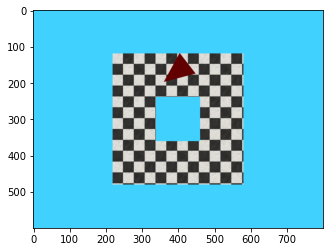

In [23]:
render1 = vis_maze.render(view='top', mode='rgb_array')
plt.imshow(render1)

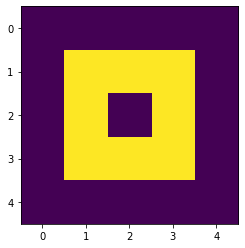

In [24]:
plt.imshow(maze1)

# test rendering egocentric panoramic images

In [25]:
obs = vis_maze.reset()

In [26]:
# pano_obs = vis_maze.render_pano(vis_maze.valid_pos[10])
# pano_obs = vis_maze.render_pano([2, 4])
# pano_obs = vis_maze.render_pano([1.5, 1.5])
# pano_obs = vis_maze.render_pano([0.5, 0.5])
pano_obs, top_obs = vis_maze.render_pano([1, 1], with_top=True)

(Debug) position = [1.5 0.  1.5], orientation = 0.0
(Debug) position = [1.5 0.  1.5], orientation = 1.5707963267948966
(Debug) position = [1.5 0.  1.5], orientation = 3.141592653589793
(Debug) position = [1.5 0.  1.5], orientation = 4.71238898038469


In [27]:
from utils.vis_visual_nav import plot_pano

In [27]:
from utils.vis_visual_nav import plot_pano

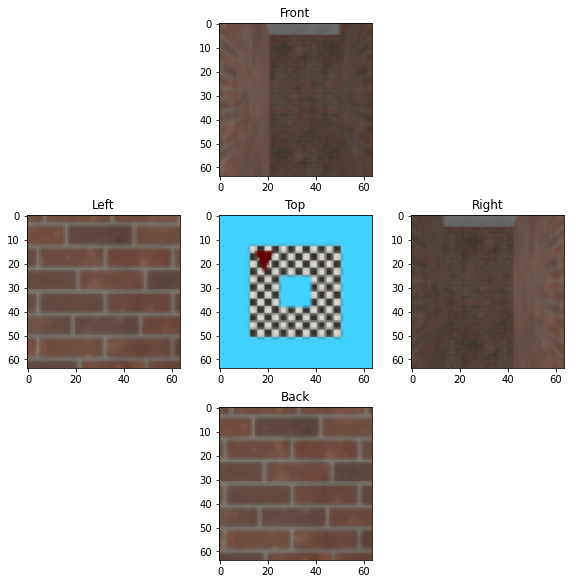

In [28]:
fig = plot_pano(pano_obs, top_obs=top_obs)

### plot full obs

(Debug) position = [1.5 0.  1.5], orientation = 0.0
(Debug) position = [1.5 0.  1.5], orientation = 1.5707963267948966
(Debug) position = [1.5 0.  1.5], orientation = 3.141592653589793
(Debug) position = [1.5 0.  1.5], orientation = 4.71238898038469
(Debug) position = [2.5 0.  1.5], orientation = 0.0
(Debug) position = [2.5 0.  1.5], orientation = 1.5707963267948966
(Debug) position = [2.5 0.  1.5], orientation = 3.141592653589793
(Debug) position = [2.5 0.  1.5], orientation = 4.71238898038469
(Debug) position = [3.5 0.  1.5], orientation = 0.0
(Debug) position = [3.5 0.  1.5], orientation = 1.5707963267948966
(Debug) position = [3.5 0.  1.5], orientation = 3.141592653589793
(Debug) position = [3.5 0.  1.5], orientation = 4.71238898038469
(Debug) position = [1.5 0.  2.5], orientation = 0.0
(Debug) position = [1.5 0.  2.5], orientation = 1.5707963267948966
(Debug) position = [1.5 0.  2.5], orientation = 3.141592653589793
(Debug) position = [1.5 0.  2.5], orientation = 4.71238898038469


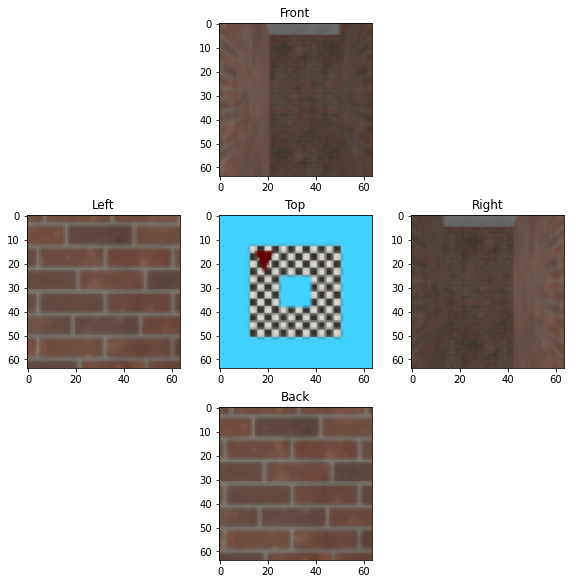

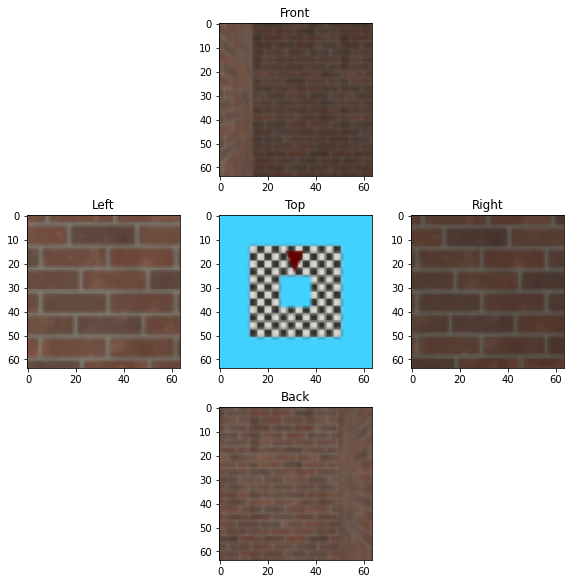

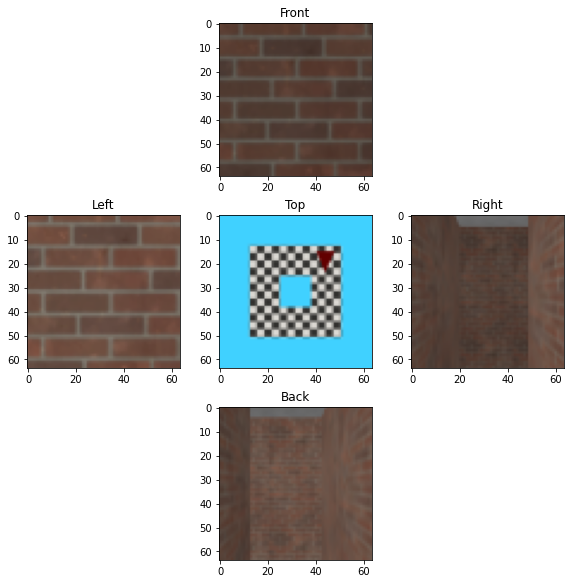

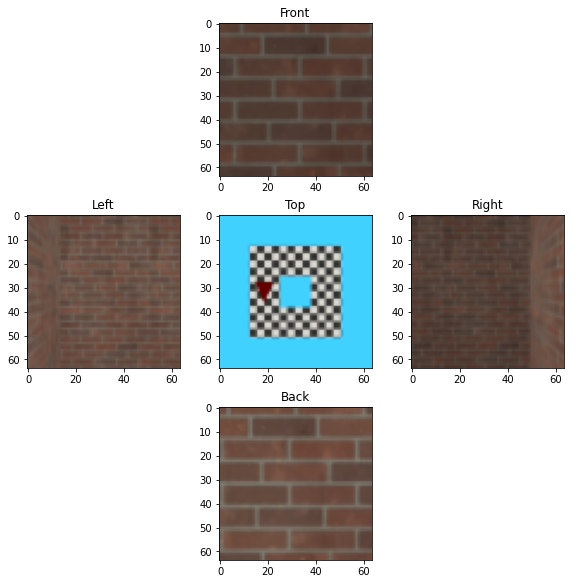

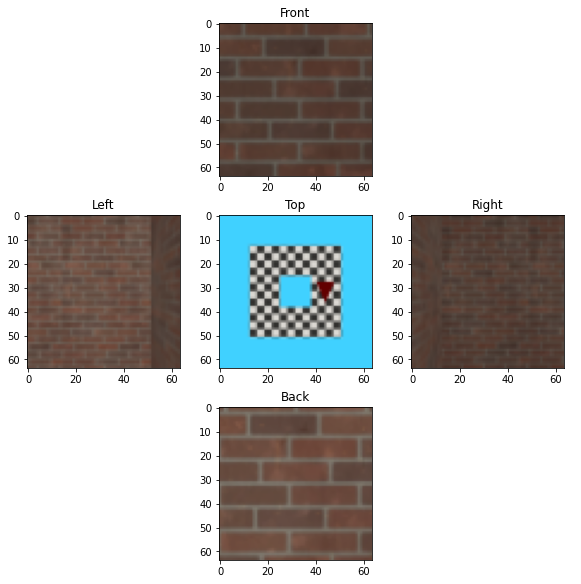

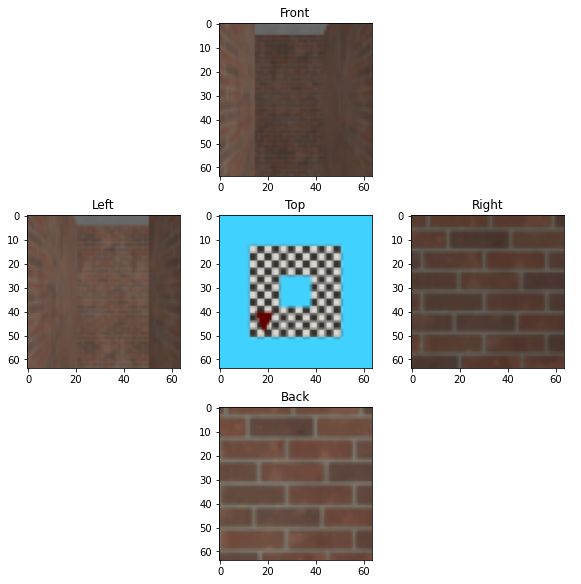

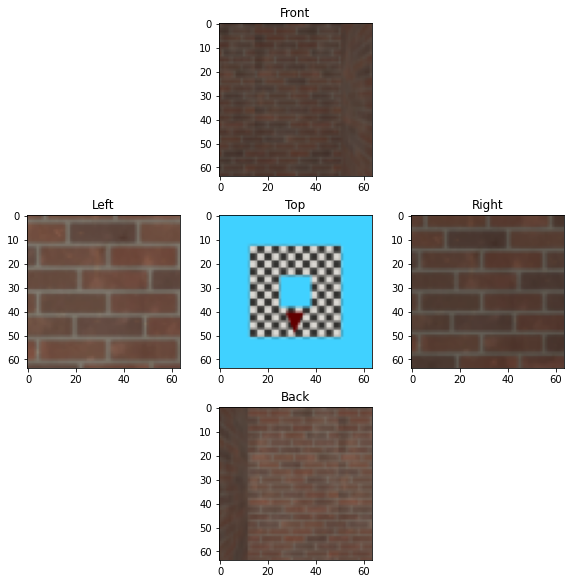

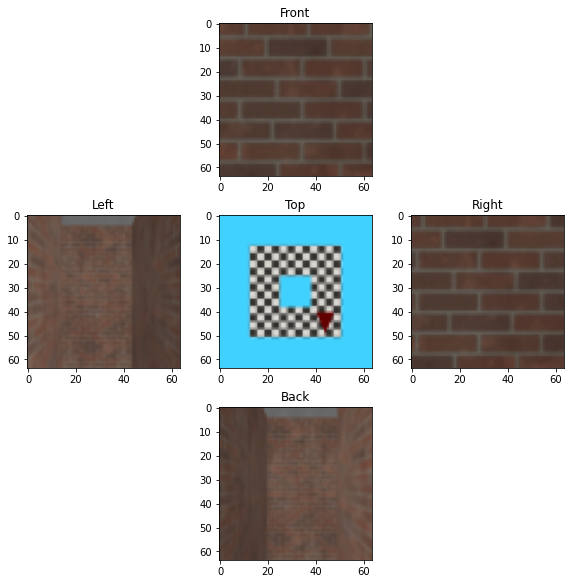

In [29]:
pos2images = vis_maze.get_all_pano(debug_top=True)

# test aggregated func

In [30]:
from nav_wrapper import MazeVisNav

In [31]:
maze2 = generate_maze(maze_size=7, decimation=0.2)

In [32]:
env = MazeVisNav(maze_map=maze2, obs_width=64, obs_height=64)

In [33]:
obs = env.reset()

(Debug) position = [1.5 0.  1.5], orientation = 0.0
(Debug) position = [1.5 0.  1.5], orientation = 1.5707963267948966
(Debug) position = [1.5 0.  1.5], orientation = 3.141592653589793
(Debug) position = [1.5 0.  1.5], orientation = 4.71238898038469
(Debug) position = [2.5 0.  1.5], orientation = 0.0
(Debug) position = [2.5 0.  1.5], orientation = 1.5707963267948966
(Debug) position = [2.5 0.  1.5], orientation = 3.141592653589793
(Debug) position = [2.5 0.  1.5], orientation = 4.71238898038469
(Debug) position = [3.5 0.  1.5], orientation = 0.0
(Debug) position = [3.5 0.  1.5], orientation = 1.5707963267948966
(Debug) position = [3.5 0.  1.5], orientation = 3.141592653589793
(Debug) position = [3.5 0.  1.5], orientation = 4.71238898038469
(Debug) position = [5.5 0.  1.5], orientation = 0.0
(Debug) position = [5.5 0.  1.5], orientation = 1.5707963267948966
(Debug) position = [5.5 0.  1.5], orientation = 3.141592653589793
(Debug) position = [5.5 0.  1.5], orientation = 4.71238898038469


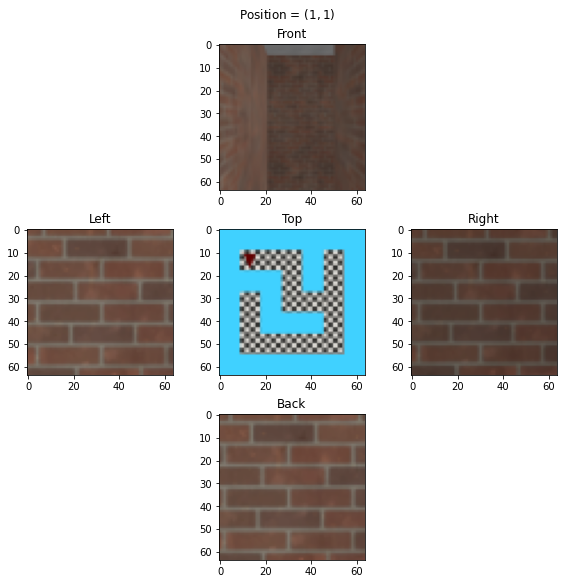

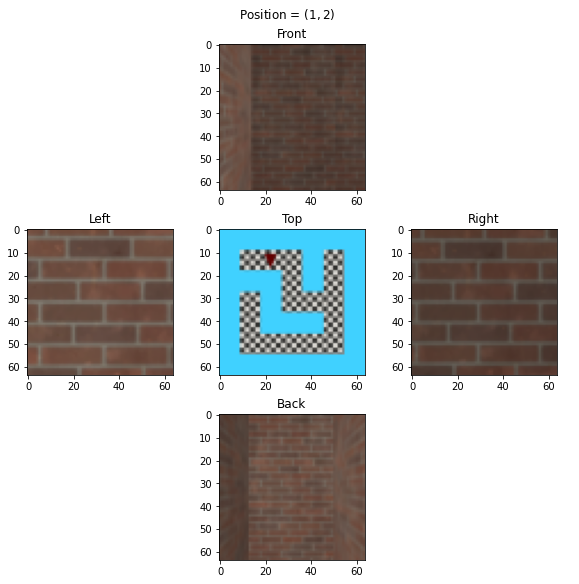

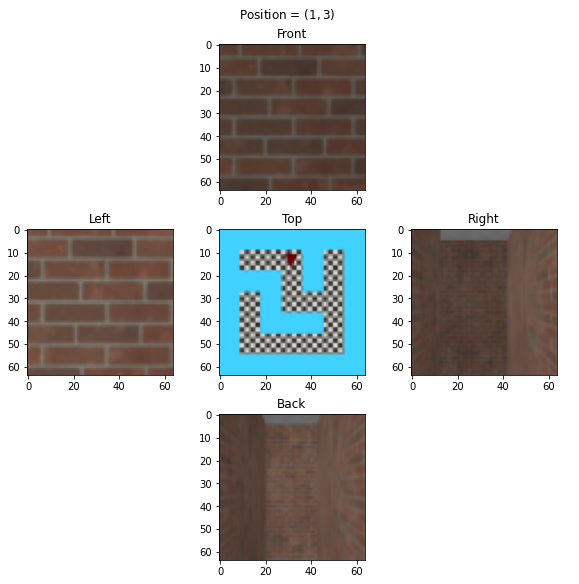

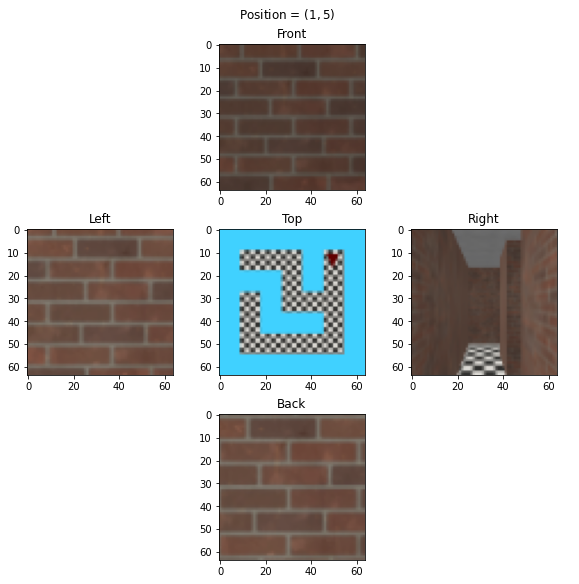

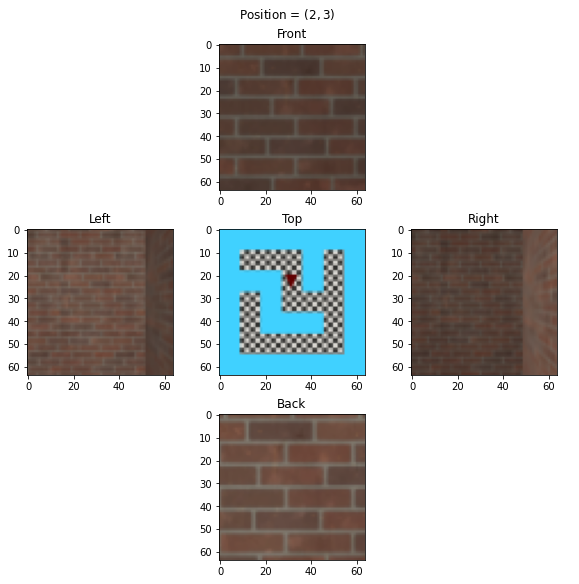

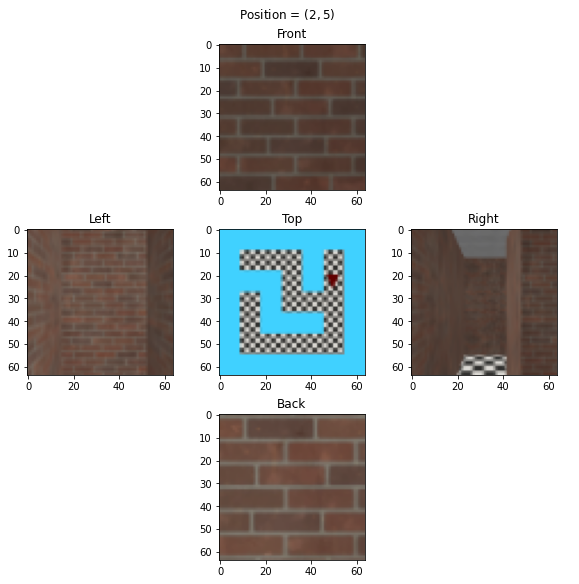

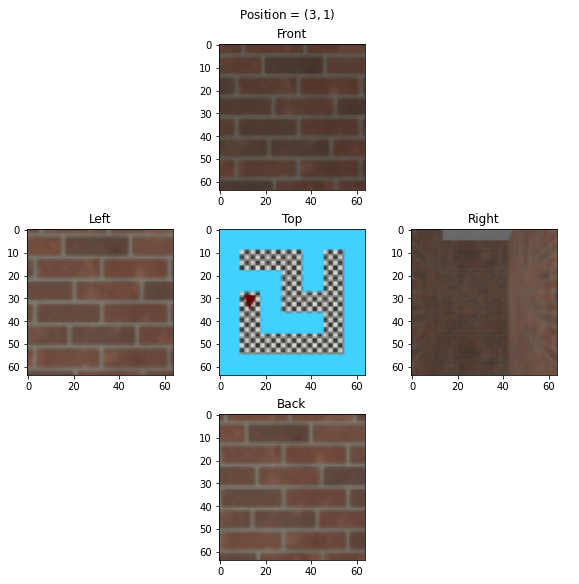

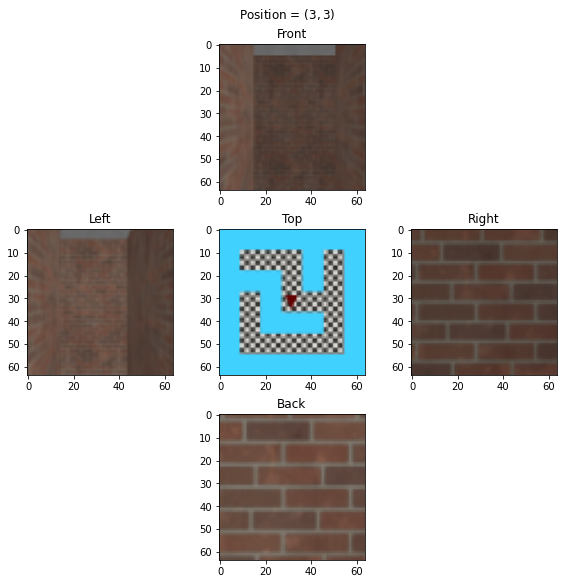

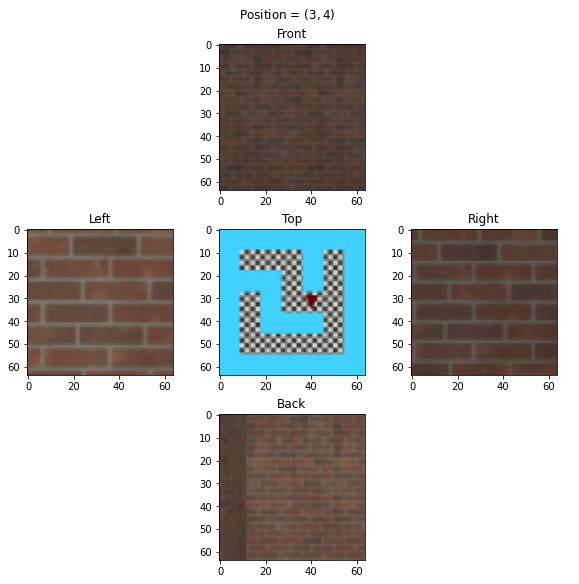

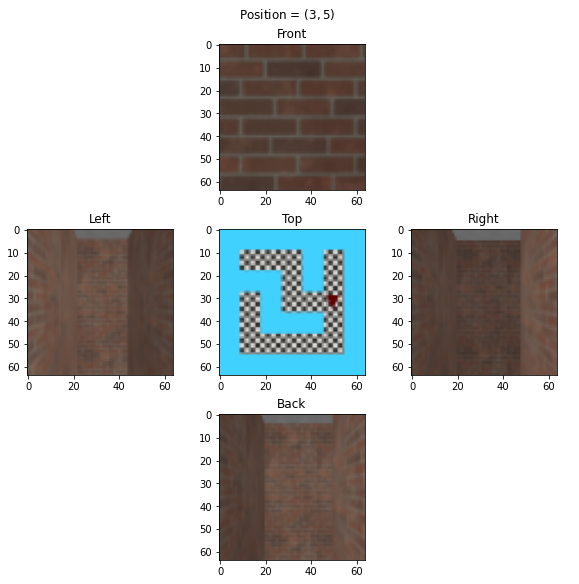

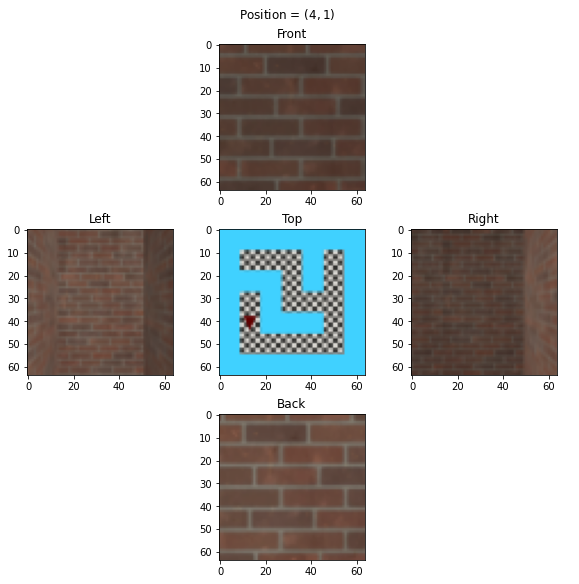

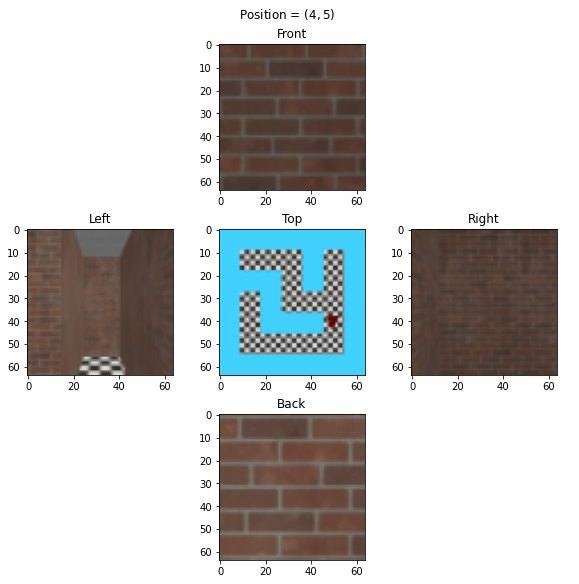

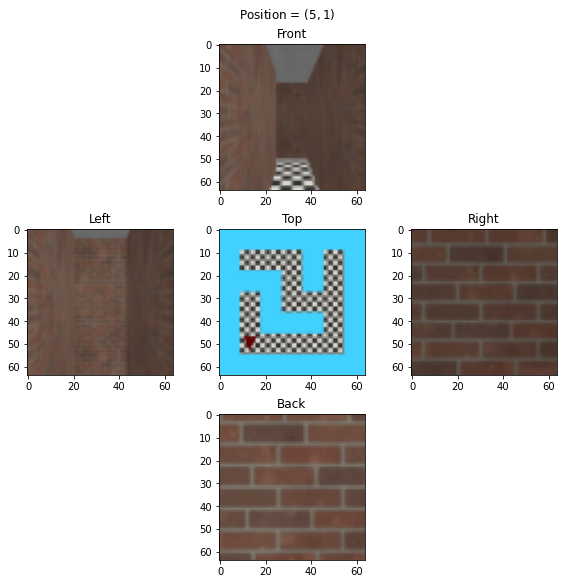

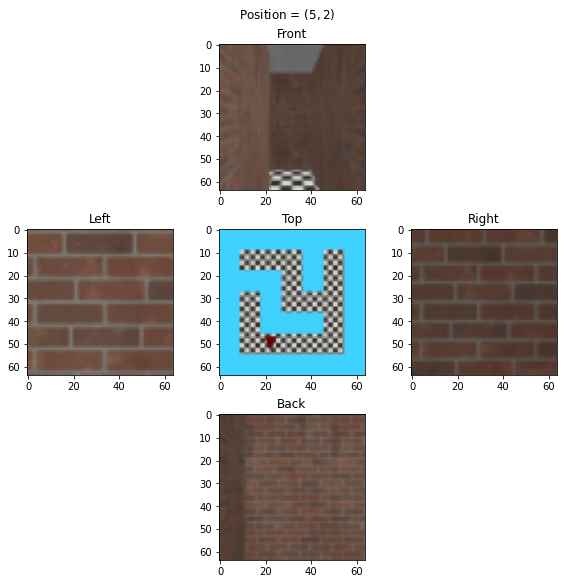

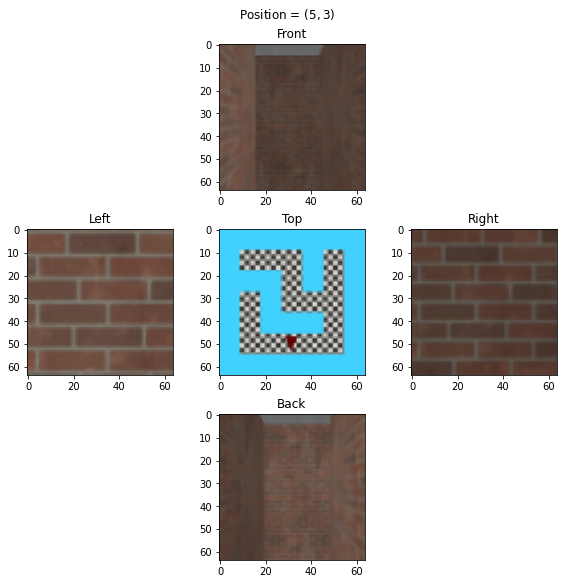

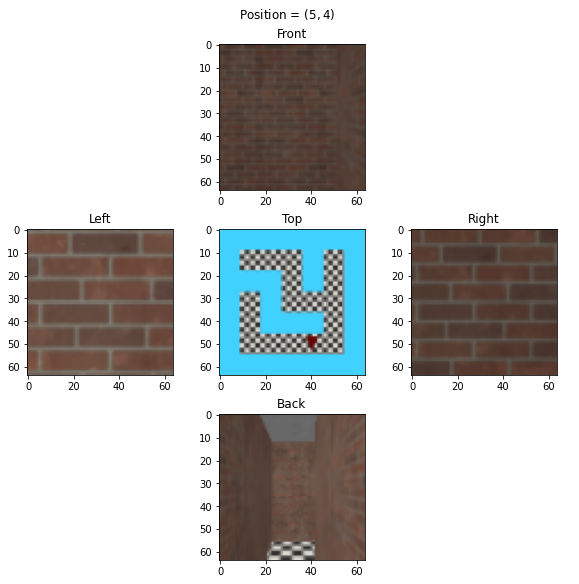

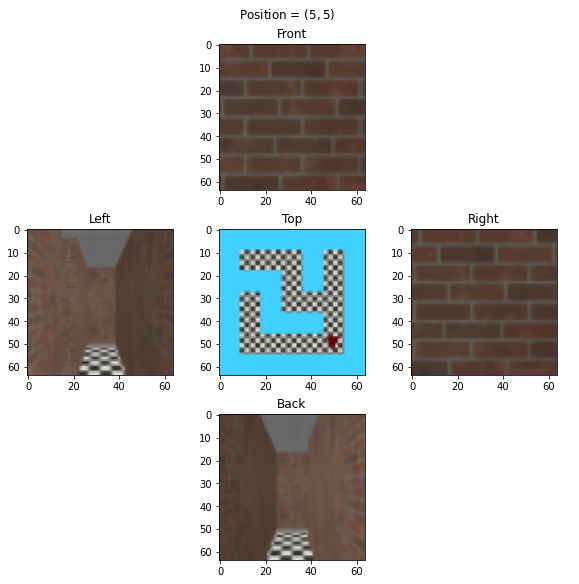

In [34]:
pano_obs = env.get_all_pano(debug_top=True)